# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:
con = sqlite3.connect('database.sqlite') 

## taking first 5000 rows for EDA
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

In [3]:
print(data.shape)
data.head(2)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
data['Score'].value_counts()

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64

In [5]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
data['Score'] = data['Score'].apply(lambda x: 0 if x<3 else 1)
data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [6]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
data[["UserId","ProfileName","Time","Text"]].duplicated().sum()

161641

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(data['Id'].size*1.0)*100

69.25890143662969

In [10]:
# this we can filter dynamically from data using
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [11]:
#combining title with body summary
final['Text'] = final['Summary'] + ' ' + final['Text']
final[['Summary','Text']].head(2)

,Summary,Text
138706,EVERY book is educational,EVERY book is educational this witty little bo...
138688,"Love the book, miss the hard cover version","Love the book, miss the hard cover version I g..."


82.53171724272389


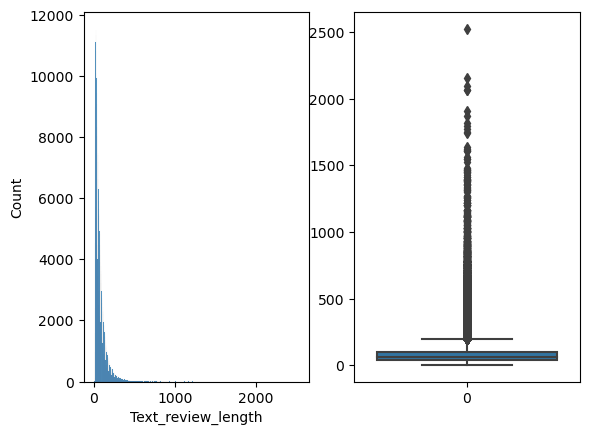

In [12]:
final['Text_review_length'] = final['Text'].apply(lambda x: len(x.split()))
plt.subplot(1,2,1)
sns.histplot(final['Text_review_length'])
plt.subplot(1,2,2)
sns.boxplot(final['Text_review_length'])
print(final['Text_review_length'].mean())

In [13]:
print(final[final['Text_review_length']>75].shape)
print(final[final['Text_review_length']>75]['Score'].value_counts())

(137587, 11)
1    112687
0     24900
Name: Score, dtype: int64


(20000, 11)
1    10000
0    10000
Name: Score, dtype: int64
140.7026


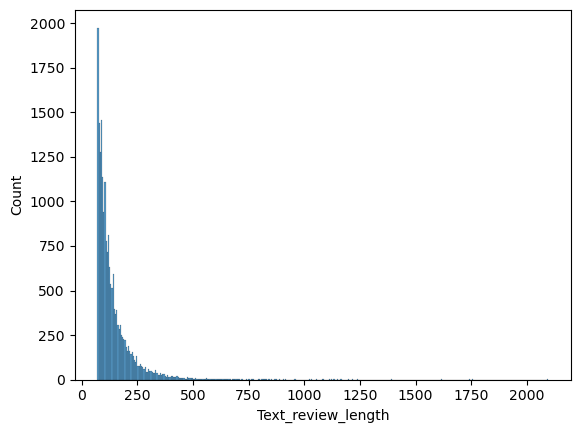

In [14]:
final = final[final['Text_review_length']>70]
# Filter out rows with label 0 and 1
filtered_df_0 = final[final['Score'] == 0].sample(n=10000, random_state=42)
filtered_df_1 = final[final['Score'] == 1].sample(n=10000, random_state=42)

# Concatenate the filtered DataFrames
filtered_df = pd.concat([filtered_df_0, filtered_df_1])

# Shuffle the concatenated dataframe
final = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(final.shape)
print(final['Score'].value_counts())
sns.histplot(final['Text_review_length'])
print(final['Text_review_length'].mean())

In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_review_length
0,322848,B000VBSL3Q,A4NW0U5TTXTJE,"Coffee Lover ""Jan""",1,1,1,1346889600,A good work a day olive oil,A good work a day olive oil Taking the review ...,76
1,467719,B0009TMZIM,A2AR54A5ATZ5W,Megan,3,4,0,1297728000,Disappointing,Disappointing I was very excited to receive th...,164
2,190238,B004APZYVG,AZKA281SH3861,Dillon,0,1,0,1322784000,"No coffee flavor at all, bad aftertaste","No coffee flavor at all, bad aftertaste I trie...",80
3,170578,B000FZWSWI,A1HOLE9R6WPT85,Mad Max,4,6,0,1262995200,NOT lower carb than Kraft or General Mills - w...,NOT lower carb than Kraft or General Mills - w...,475
4,189439,B001EO5Q64,A3JVCRSVH20SLJ,Amazon Fan,1,1,1,1330473600,Excellent product!!!,Excellent product!!! Nutiva's brand of organic...,347


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
from nltk.corpus import stopwords
# set(stopwords.words('english'))

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#reviews
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in set(stopwords.words('english')))
    preprocessed_reviews.append(sentance.strip())
    
# # Same we can do for title_Summary as well and use it with text review, skipping as we have combined text and title
# title_summaries = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in set(stopwords.words('english')))
#     title_summaries.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [48:29<00:00,  6.87it/s]


# [4] Featurization/Embedding

## [4.1] BAG OF WORDS

In [20]:
#BoW
count_vect = CountVectorizer(max_features=5000)
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['ability' 'able' 'absolute' 'absolutely' 'absorb' 'absorbed' 'acai'
 'accept' 'acceptable' 'access']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words  5000


## [4.2] Bi-Grams and n-Grams.

In [21]:
#bi-gram, tri-gram and n-gram
# removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [22]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able buy' 'able eat' 'able find' 'able get' 'absolute'
 'absolutely' 'absolutely delicious' 'absolutely love']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.4] Word2Vec

In [23]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [24]:
# Using Google News Word2Vectors
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.7900177836418152), ('fantastic', 0.7789985537528992), ('good', 0.7778310179710388), ('wonderful', 0.7725399732589722), ('amazing', 0.7701253890991211), ('excellent', 0.7639433145523071), ('perfect', 0.7107051014900208), ('incredible', 0.6893037557601929), ('fabulous', 0.6821308135986328), ('delicious', 0.6547084450721741)]
[('best', 0.7402095198631287), ('greatest', 0.6821853518486023), ('horrible', 0.6756666302680969), ('terrible', 0.6661695241928101), ('awful', 0.6637780666351318), ('hardly', 0.6507418751716614), ('ever', 0.6419024467468262), ('strangest', 0.6409161686897278), ('nicest', 0.6248576641082764), ('hated', 0.6081883907318115)]


In [25]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12387
sample words  ['like', 'would', 'one', 'taste', 'good', 'product', 'flavor', 'coffee', 'food', 'tea', 'great', 'get', 'really', 'much', 'amazon', 'even', 'also', 'love', 'time', 'use', 'buy', 'first', 'little', 'tried', 'make', 'well', 'try', 'water', 'better', 'could', 'sugar', 'find', 'eat', 'price', 'made', 'dog', 'best', 'box', 'chocolate', 'used', 'bag', 'two', 'bought', 'way', 'found', 'cup', 'think', 'know', 'drink', 'sweet']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2V

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:23<00:00, 138.92it/s]

20000
50


#### [4.4.1.2] TFIDF weighted W2V

In [31]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10, max_features=5000)
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are using
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:58<00:00, 22.27it/s]


# [5.1] KNN

#### brute force version

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [34]:
# Initialize the X_labels and y_label
X_labels = [final_counts.toarray(), final_bigram_counts.toarray(),final_tf_idf.toarray(), sent_vectors, tfidf_sent_vectors]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize KNN parameters for hyperparameter tuning
k_values = list(range(1, 30))  # Example range of k values

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for k in tqdm(k_values, desc=f"X_label {i + 1}"):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train, y_train)
        y_pred_prob = knn.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_scores.append(auc)

    best_k = k_values[np.argmax(auc_scores)]
    results[f'{embedding[i]}'] = {'best_k': best_k, 'auc_scores': auc_scores}

X_label 5: 100%|███████████████████████████████████████████████████████████████████████| 29/29 [00:33<00:00,  1.16s/it]


In [35]:
# results

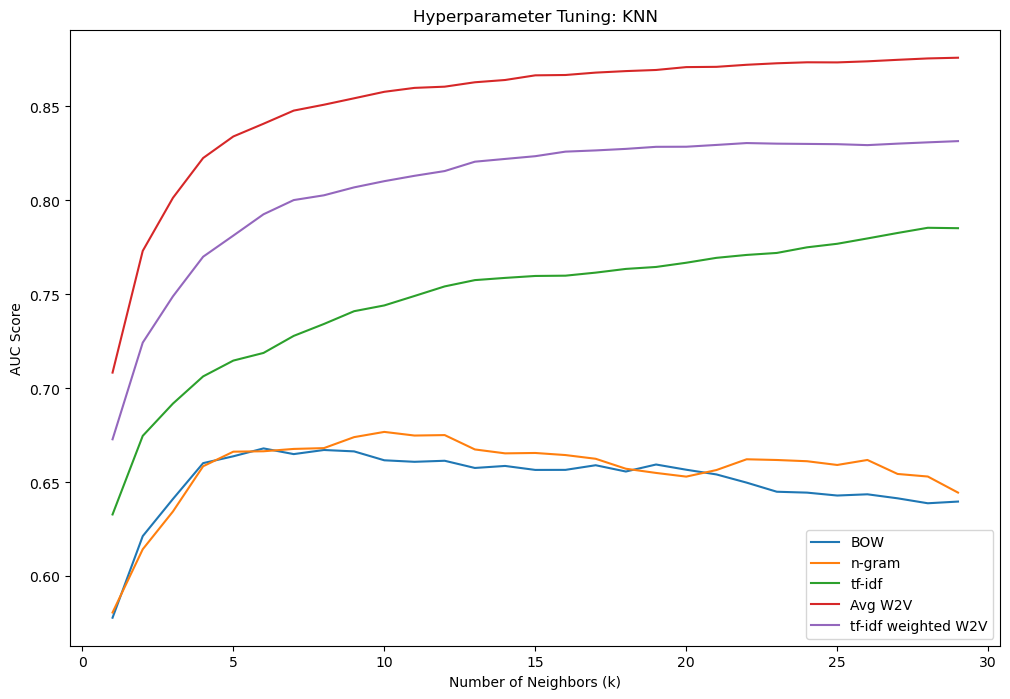

In [36]:
# Plot performance on train and cross-validation data for each X_label
plt.figure(figsize=(12, 8))
for i, (label, result) in enumerate(results.items()):
    plt.plot(k_values, result['auc_scores'], label=label)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.legend()
plt.title('Hyperparameter Tuning: KNN')
plt.show()

In [37]:
# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_k = result['best_k']
    best_models[label] = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')


Confusion Matrix for BOW:
 [[2394  666]
 [ 996 1944]]

Confusion Matrix for n-gram:
 [[2319  741]
 [ 856 2084]]

Confusion Matrix for tf-idf:
 [[2219  841]
 [ 670 2270]]

Confusion Matrix for Avg W2V:
 [[2120  940]
 [ 587 2353]]

Confusion Matrix for tf-idf weighted W2V:
 [[2120  940]
 [ 587 2353]]


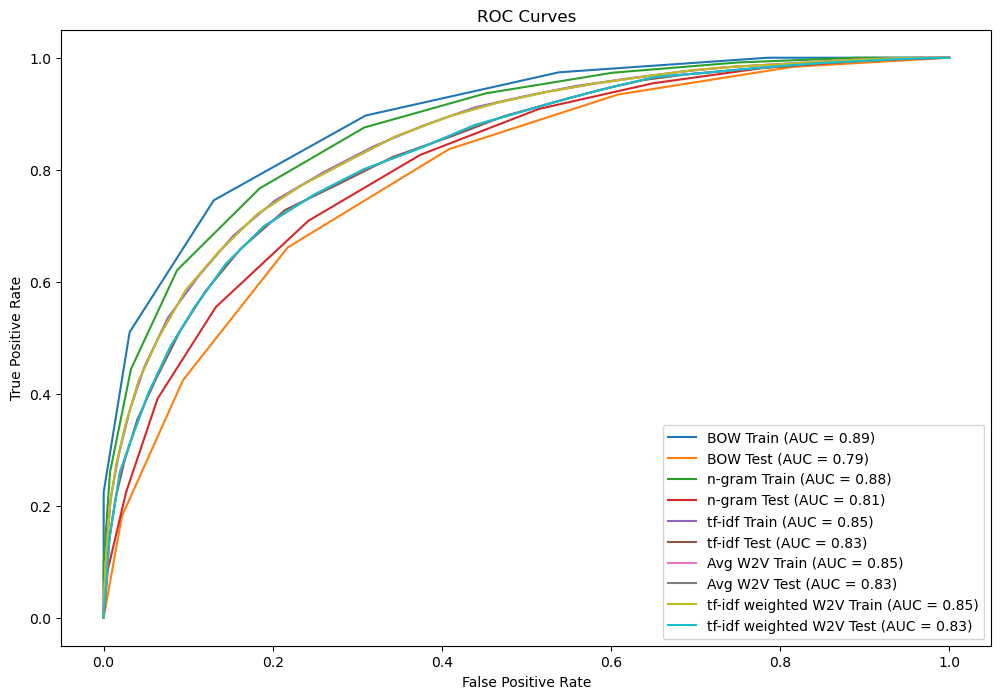

In [38]:
# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()

In [41]:
# Summarize the results in a table
table = PrettyTable()
table.field_names = ["X_label", "Best K", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_k'], max(result['auc_scores'])])
print(table)

+---------+--------+--------------------+
| X_label | Best K |      Test AUC      |
+---------+--------+--------------------+
|   BOW   |   22   | 0.7295074696545285 |
+---------+--------+--------------------+


#### kd tree version

X_label 5: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 15.22s/it]


{'BOW': {'best_k': 22, 'auc_scores': [0.6135509759459339, 0.6807899826597306, 0.7086141123115914, 0.7181749366413234, 0.7259164777021921, 0.7295074696545285, 0.7260853785958827]}, 'n-gram': {'best_k': 18, 'auc_scores': [0.6167749321951003, 0.6727783335556444, 0.6713592659285935, 0.6726895758303321, 0.6732661397892491, 0.6587588368680805, 0.6549896069538927]}, 'tf-idf': {'best_k': 26, 'auc_scores': [0.5497410075141167, 0.6913454270597127, 0.7312040927482103, 0.7494134320394824, 0.7580730625583566, 0.7658218843092792, 0.7714569716775599]}, 'Avg W2V': {'best_k': 26, 'auc_scores': [0.7731541505491086, 0.8407885932150638, 0.8577788337557245, 0.8640547330043128, 0.8687927393179493, 0.8721520830554443, 0.873987483882442]}, 'tf-idf weighted W2V': {'best_k': 22, 'auc_scores': [0.7243556311413454, 0.792623716153128, 0.8102379285047352, 0.8220651593970921, 0.8274137432750879, 0.8305109821706459, 0.8294127095282557]}}


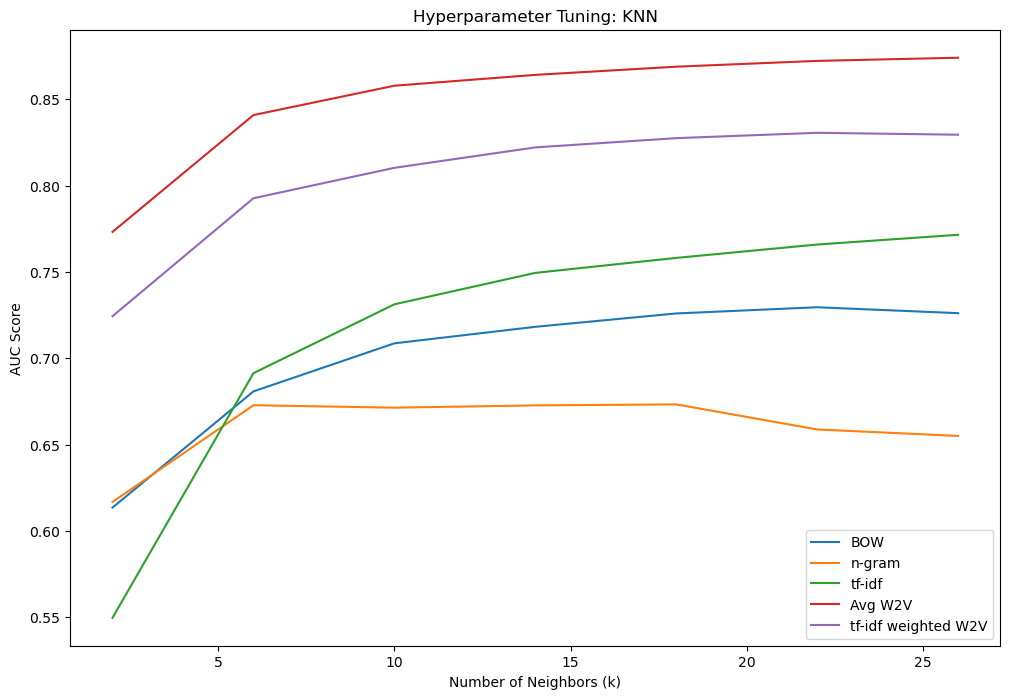


Confusion Matrix for BOW:
 [[2233  827]
 [ 674 2266]]

Confusion Matrix for n-gram:
 [[2263  797]
 [ 717 2223]]

Confusion Matrix for tf-idf:
 [[2206  854]
 [ 652 2288]]

Confusion Matrix for Avg W2V:
 [[2206  854]
 [ 652 2288]]

Confusion Matrix for tf-idf weighted W2V:
 [[2233  827]
 [ 674 2266]]


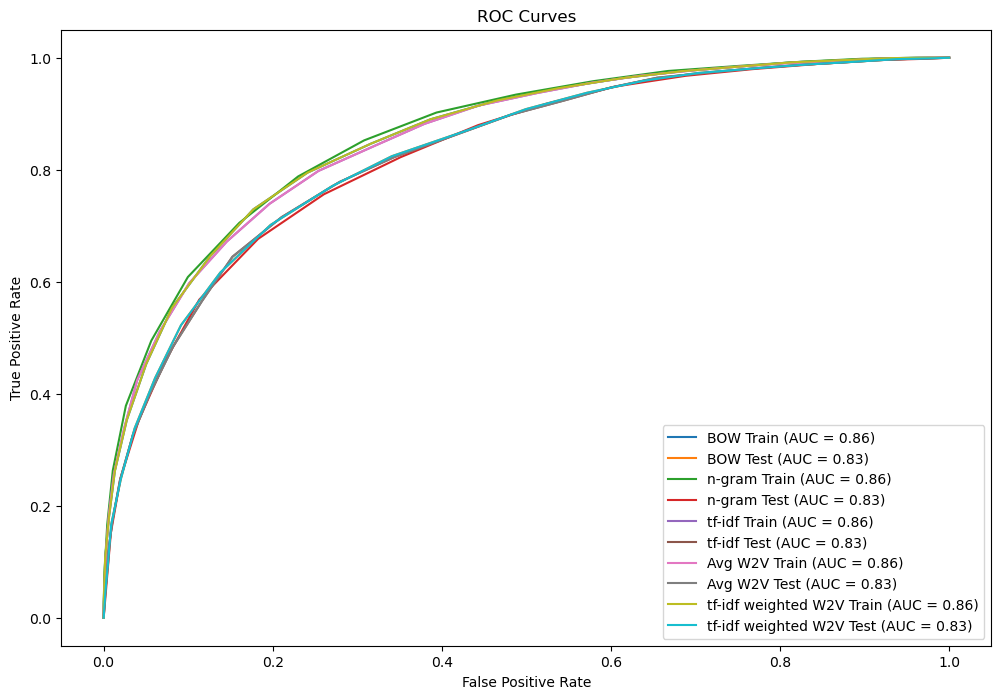

+---------------------+--------+--------------------+
|       X_label       | Best K |      Test AUC      |
+---------------------+--------+--------------------+
|         BOW         |   22   | 0.7295074696545285 |
|        n-gram       |   18   | 0.6732661397892491 |
|        tf-idf       |   26   | 0.7714569716775599 |
|       Avg W2V       |   26   | 0.873987483882442  |
| tf-idf weighted W2V |   22   | 0.8305109821706459 |
+---------------------+--------+--------------------+


In [42]:
# Additional feature sets with restrictions on max features
count_vect = CountVectorizer(min_df=10, max_features=500)
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)

final_counts = count_vect.fit_transform(preprocessed_reviews)
final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)


# Initialize the X_labels and y_label
X_labels = [final_counts.toarray(), final_bigram_counts.toarray(),final_tf_idf.toarray(), sent_vectors, tfidf_sent_vectors]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize KNN parameters for hyperparameter tuning
k_values = list(range(2,30,4))  # Example range of k values

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for k in tqdm(k_values, desc=f"X_label {i + 1}"):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        knn.fit(X_train, y_train)
        y_pred_prob = knn.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_scores.append(auc)

    best_k = k_values[np.argmax(auc_scores)]
    results[f'{embedding[i]}'] = {'best_k': best_k, 'auc_scores': auc_scores}
    
print(results)


# Plot performance on train and cross-validation data for each X_label
plt.figure(figsize=(12, 8))
for i, (label, result) in enumerate(results.items()):
    plt.plot(k_values, result['auc_scores'], label=label)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.legend()
plt.title('Hyperparameter Tuning: KNN')
plt.show()


# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_k = result['best_k']
    best_models[label] = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
    

# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()


# Summarize the results in a table
table = PrettyTable()
table.field_names = ["X_label", "Best K", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_k'], max(result['auc_scores'])])
print(table)

# [5.2] Naive-Bayes

X_label 2: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.36it/s]


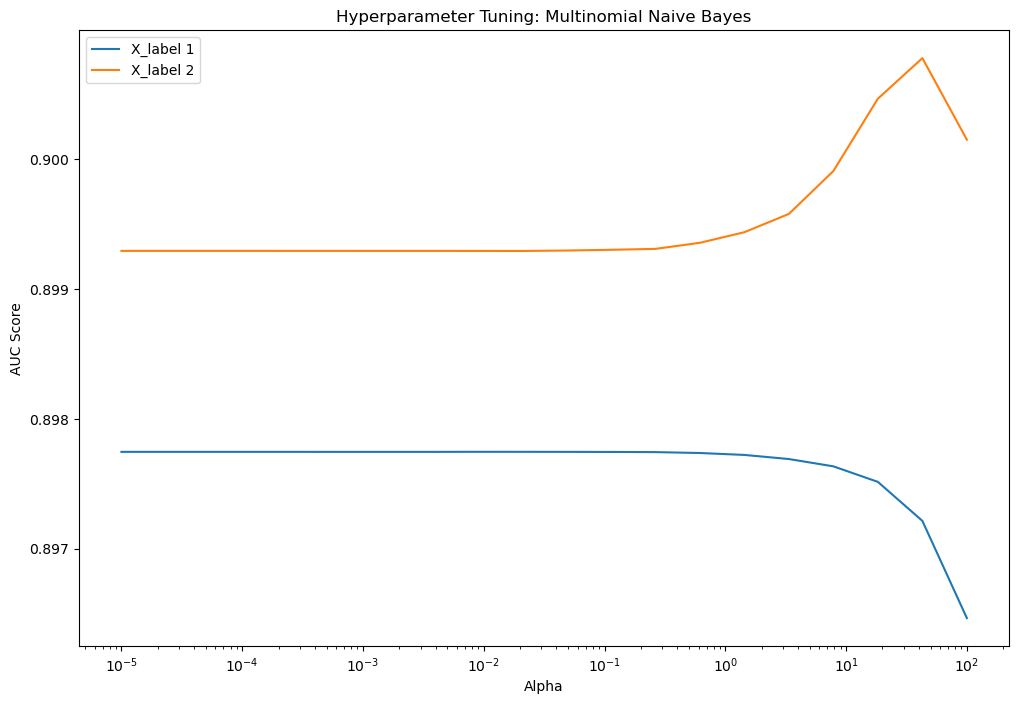


Confusion Matrix for X_label 1:
 [[2381  679]
 [ 464 2476]]

Top 10 Features for Positive Class (X_label 1):
great
tea
good
like
coffee
one
love
flavor
taste
food

Top 10 Features for Negative Class (X_label 1):
like
product
taste
would
coffee
one
flavor
good
tea
food

Confusion Matrix for X_label 2:
 [[2333  727]
 [ 420 2520]]

Top 10 Features for Positive Class (X_label 2):
great
tea
good
like
coffee
one
love
flavor
taste
food

Top 10 Features for Negative Class (X_label 2):
like
product
taste
would
coffee
one
flavor
good
tea
food


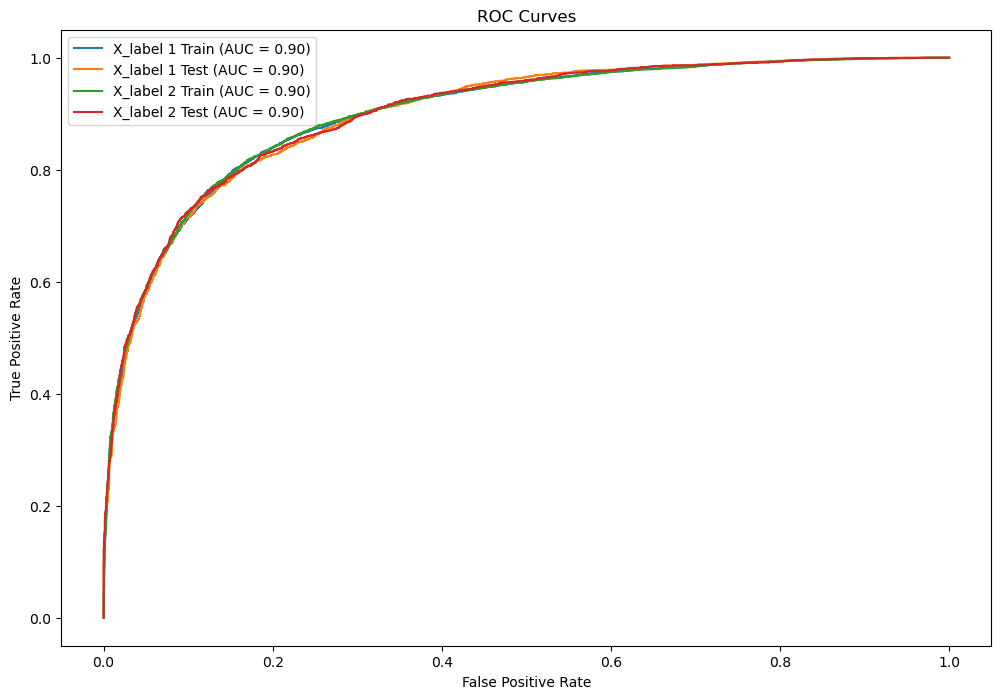

+-----------+----------------------+--------------------+
|  X_label  |      Best Alpha      |      Test AUC      |
+-----------+----------------------+--------------------+
| X_label 1 | 0.008858667904100823 | 0.8977469876839623 |
| X_label 2 |  42.81332398719387   | 0.9007808679027167 |
+-----------+----------------------+--------------------+


In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Initialize the X_labels and y_label
X_labels = [final_counts.toarray(),final_tf_idf.toarray()]
embedding = ["BOW","n-gram"]

y_label = final['Score']


# Initialize hyperparameters for hyperparameter tuning
alpha_values = np.logspace(-5, 2, num=20)  # Example range of alpha values

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for alpha in tqdm(alpha_values, desc=f"X_label {i + 1}"):
        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(X_train, y_train)
        y_pred_prob = mnb.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_prob)
        auc_scores.append(auc_score)

    best_alpha = alpha_values[np.argmax(auc_scores)]
    results[f'X_label {i + 1}'] = {'best_alpha': best_alpha, 'auc_scores': auc_scores}

    
# Plot performance on train and cross-validation data for each X_label
plt.figure(figsize=(12, 8))
for i, (label, result) in enumerate(results.items()):
    plt.semilogx(alpha_values, result['auc_scores'], label=label)
plt.xlabel('Alpha')
plt.ylabel('AUC Score')
plt.legend()
plt.title('Hyperparameter Tuning: Multinomial Naive Bayes')
plt.show()

# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_alpha = result['best_alpha']
    best_models[label] = MultinomialNB(alpha=best_alpha)
    

# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)
    
    # Get feature names for CountVectorizer or TfidfVectorizer
    if label == 'X_label 1':  # BOW
        feature_names = count_vect.get_feature_names_out()
    elif label == 'X_label 2':  # TF-IDF
        feature_names = tf_idf_vect.get_feature_names_out()

    # Print top 10 features for positive and negative classes
    print(f'\nTop 10 Features for Positive Class ({label}):')
    pos_class_prob_sorted = np.argsort(-model.feature_log_prob_[1])
    for i in pos_class_prob_sorted[:10]:
        print(feature_names[i])

    print(f'\nTop 10 Features for Negative Class ({label}):')
    neg_class_prob_sorted = np.argsort(-model.feature_log_prob_[0])
    for i in neg_class_prob_sorted[:10]:
        print(feature_names[i])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()


# Summarize the results in a table
table = PrettyTable()
table.field_names = ["X_label", "Best Alpha", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_alpha'], max(result['auc_scores'])])
print(table)

# [5.3] Logistic regression

X_label 5: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


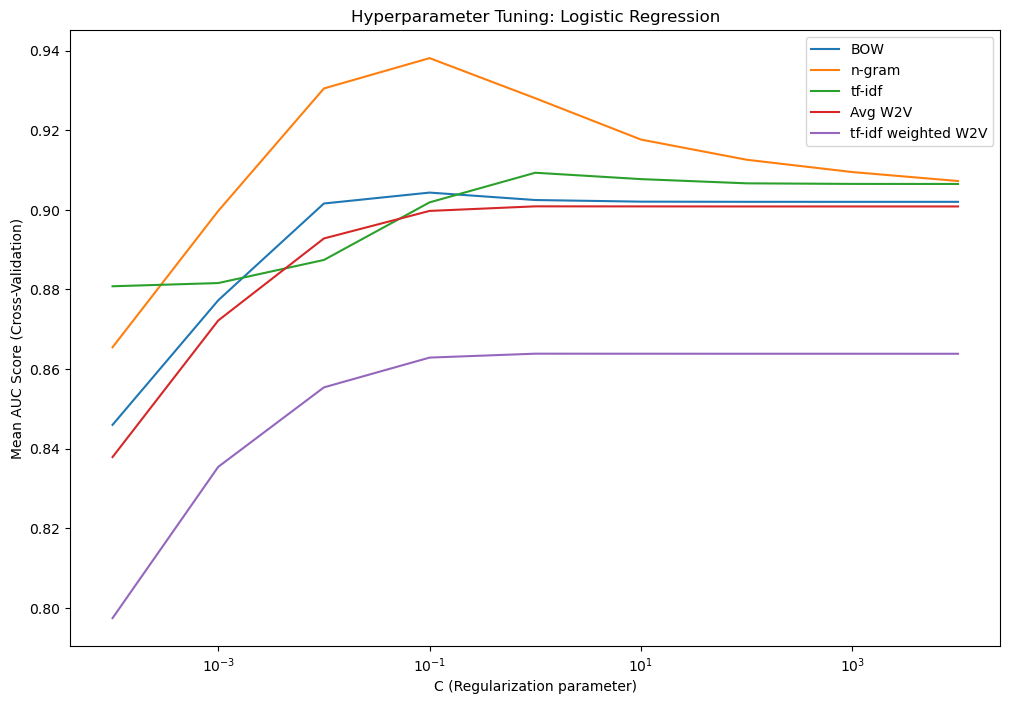


Confusion Matrix for BOW:
 [[2406  654]
 [ 616 2324]]
Feature 'already' changed by 2.97%
Feature 'also' changed by 16.78%
Feature 'alternative' changed by 1138.68%

Confusion Matrix for n-gram:
 [[2406  654]
 [ 616 2324]]
Feature 'already' changed by 4.71%
Feature 'also' changed by 11.11%
Feature 'alternative' changed by 968.40%

Confusion Matrix for tf-idf:
 [[2412  648]
 [ 609 2331]]
Feature 'aftertaste' changed by 2.91%
Feature 'ago' changed by 3.27%
Feature 'almost' changed by 4.71%
Feature 'already' changed by 6.17%
Feature 'also' changed by 7.56%
Feature 'alternative' changed by 19.16%

Confusion Matrix for Avg W2V:
 [[2412  648]
 [ 609 2331]]
Feature 'almost' changed by 2.97%
Feature 'already' changed by 4.03%
Feature 'also' changed by 6.19%
Feature 'alternative' changed by 15.32%

Confusion Matrix for tf-idf weighted W2V:
 [[2412  648]
 [ 609 2331]]
Feature 'almost' changed by 3.46%
Feature 'already' changed by 4.91%
Feature 'also' changed by 5.83%
Feature 'alternative' change

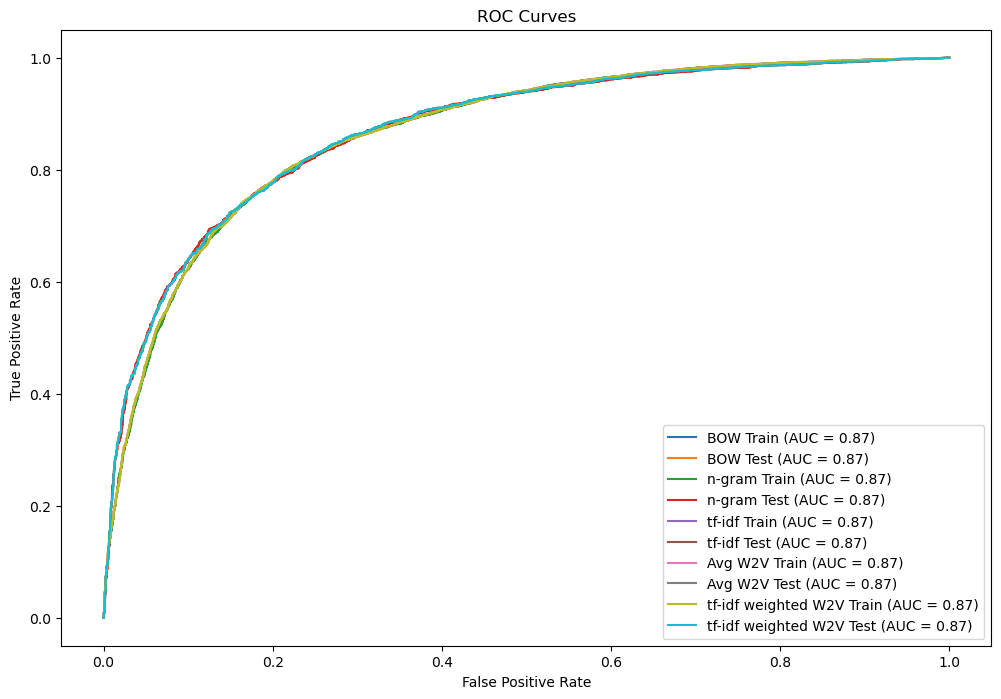

+---------------------+--------+--------------------+
|       X_label       | Best C |      Test AUC      |
+---------------------+--------+--------------------+
|         BOW         |  0.1   | 0.9043381017743766 |
|        n-gram       |  0.1   | 0.9381152722447231 |
|        tf-idf       |   1    | 0.9093262409969199 |
|       Avg W2V       |   1    | 0.9008825711437781 |
| tf-idf weighted W2V |   1    | 0.8638734893156315 |
+---------------------+--------+--------------------+


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Initialize the X_labels and y_label
X_labels = [final_counts.toarray(), final_bigram_counts.toarray(),final_tf_idf.toarray(), np.array(sent_vectors),
            np.array(tfidf_sent_vectors)]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize hyperparameters for hyperparameter tuning
C_values = [10 ** x for x in range(-4, 5)]  # Example range of C values

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for C in tqdm(C_values, desc=f"X_label {i + 1}"):
        lr = LogisticRegression(C=C, max_iter=1000)
        auc_scores_cv = cross_val_score(lr, X_train, y_train, cv=3, scoring='roc_auc')
        auc_scores.append(np.mean(auc_scores_cv))

    best_C = C_values[np.argmax(auc_scores)]
    results[f'{embedding[i]}'] = {'best_C': best_C, 'auc_scores': auc_scores}

    
# Plot performance on train and cross-validation data for each X_label
plt.figure(figsize=(12, 8))
for i, (label, result) in enumerate(results.items()):
    plt.semilogx(C_values, result['auc_scores'], label=label)
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Mean AUC Score (Cross-Validation)')
plt.legend()
plt.title('Hyperparameter Tuning: Logistic Regression')
plt.show()


# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_C = result['best_C']
    best_models[label] = LogisticRegression(C=best_C, max_iter=1000)

    
# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)
    
    # Perturbation test
    original_weights = model.coef_[0]
    
    epsilon = np.random.normal(loc=0, scale=0.01, size=X_train.shape)  # Adding noise to features
    X_perturbed = X_train + epsilon
    model.fit(X_perturbed, y_train)
    perturbed_weights = model.coef_[0]
    
    epsilon = 1e-6
    original_weights += epsilon
    perturbed_weights += epsilon
    
    percentage_change = np.abs((original_weights - perturbed_weights) / original_weights) * 100
    percentiles = np.percentile(percentage_change, range(0, 101, 10))
    
    threshold = 2.5
    for percentile, feature_name in zip(percentiles, feature_names):
        if percentile > threshold:
            print(f"Feature '{feature_name}' changed by {percentile:.2f}%")

    # Feature importance
    if label == 'X_label 1' or label == 'X_label 2':  # BOW or TF-IDF
        feature_names = count_vect.get_feature_names() if label == 'X_label 1' else tf_idf_vect.get_feature_names()
        coef = model.coef_
        pos_features = np.argsort(coef[0])[::-1][:10]
        neg_features = np.argsort(coef[0])[:10]
        print(f"\nTop 10 Positive Features for {label}:")
        for i in pos_features:
            print(feature_names[i])
        print(f"\nTop 10 Negative Features for {label}:")
        for i in neg_features:
            print(feature_names[i])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()


# Summarize the results in a table
table = PrettyTable()
table.field_names = ["X_label", "Best C", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_C'], max(result['auc_scores'])])
print(table)

#### using L2 Regularization

X_label 5: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]


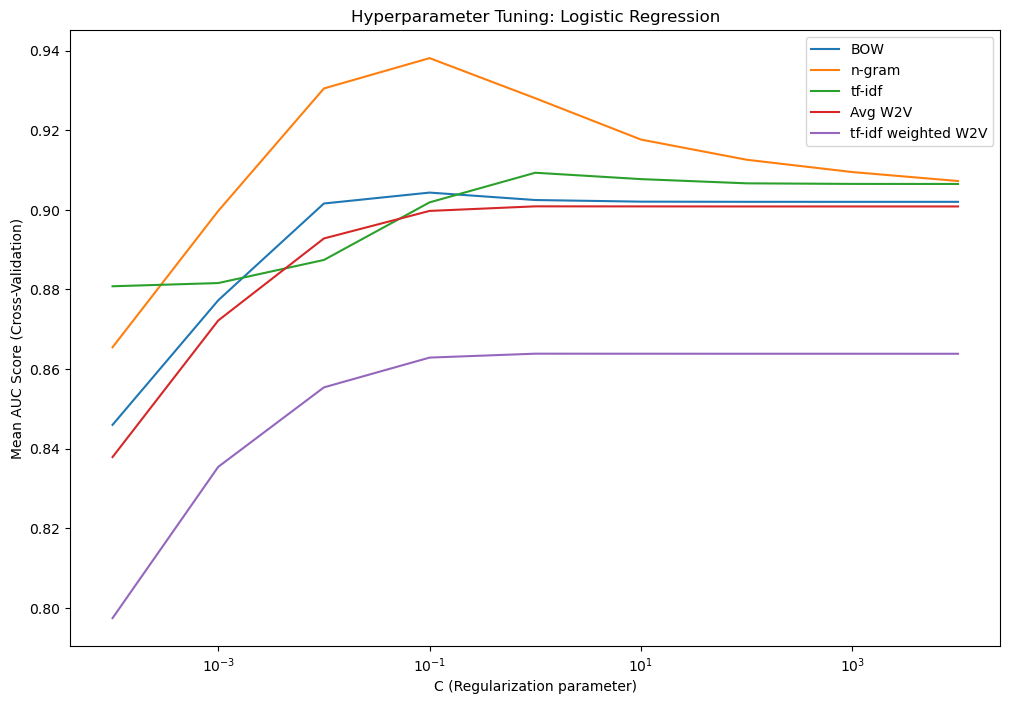


Confusion Matrix for BOW:
 [[2406  654]
 [ 616 2324]]
Feature 'already' changed by 3.72%
Feature 'also' changed by 6.84%
Feature 'alternative' changed by 458.20%

Sparsity for BOW: 0.0000

Confusion Matrix for n-gram:
 [[2406  654]
 [ 616 2324]]
Feature 'already' changed by 2.64%
Feature 'also' changed by 6.90%
Feature 'alternative' changed by 114.53%

Sparsity for n-gram: 0.0000

Confusion Matrix for tf-idf:
 [[2412  648]
 [ 609 2331]]
Feature 'aftertaste' changed by 3.27%
Feature 'ago' changed by 3.95%
Feature 'almost' changed by 5.17%
Feature 'already' changed by 6.78%
Feature 'also' changed by 11.95%
Feature 'alternative' changed by 36.80%

Sparsity for tf-idf: 0.0000

Confusion Matrix for Avg W2V:
 [[2412  648]
 [ 609 2331]]
Feature 'ago' changed by 3.06%
Feature 'almost' changed by 4.78%
Feature 'already' changed by 8.17%
Feature 'also' changed by 13.38%
Feature 'alternative' changed by 46.10%

Sparsity for Avg W2V: 0.0000

Confusion Matrix for tf-idf weighted W2V:
 [[2412  648]

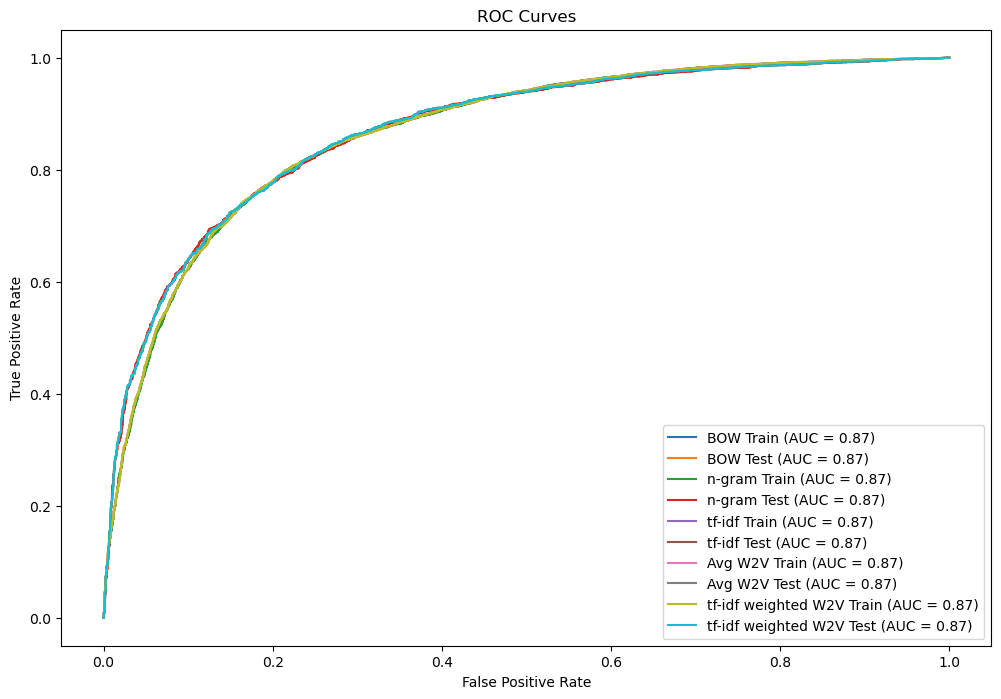

+---------------------+--------+--------------------+
|       X_label       | Best C |      Test AUC      |
+---------------------+--------+--------------------+
|         BOW         |  0.1   | 0.9043381017743766 |
|        n-gram       |  0.1   | 0.9381152722447231 |
|        tf-idf       |   1    | 0.9093262409969199 |
|       Avg W2V       |   1    | 0.9008825711437781 |
| tf-idf weighted W2V |   1    | 0.8638734893156315 |
+---------------------+--------+--------------------+


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Initialize the X_labels and y_label
X_labels = [final_counts.toarray(), final_bigram_counts.toarray(),final_tf_idf.toarray(), np.array(sent_vectors),
            np.array(tfidf_sent_vectors)]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize hyperparameters for hyperparameter tuning
C_values = [10 ** x for x in range(-4, 5)]  # Example range of C values

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for C in tqdm(C_values, desc=f"X_label {i + 1}"):
        lr = LogisticRegression(C=C, max_iter=1000,penalty='l2')
        auc_scores_cv = cross_val_score(lr, X_train, y_train, cv=3, scoring='roc_auc')
        auc_scores.append(np.mean(auc_scores_cv))

    best_C = C_values[np.argmax(auc_scores)]
    results[f'{embedding[i]}'] = {'best_C': best_C, 'auc_scores': auc_scores}

    
# Plot performance on train and cross-validation data for each X_label
plt.figure(figsize=(12, 8))
for i, (label, result) in enumerate(results.items()):
    plt.semilogx(C_values, result['auc_scores'], label=label)
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Mean AUC Score (Cross-Validation)')
plt.legend()
plt.title('Hyperparameter Tuning: Logistic Regression')
plt.show()


# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_C = result['best_C']
    best_models[label] = LogisticRegression(C=best_C, max_iter=1000,penalty='l2')

    
# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)
    
    # Perturbation test
    original_weights = model.coef_[0]
    
    epsilon = np.random.normal(loc=0, scale=0.01, size=X_train.shape)  # Adding noise to features
    X_perturbed = X_train + epsilon
    model.fit(X_perturbed, y_train)
    perturbed_weights = model.coef_[0]
    
    epsilon = 1e-6
    original_weights += epsilon
    perturbed_weights += epsilon
    
    percentage_change = np.abs((original_weights - perturbed_weights) / original_weights) * 100
    percentiles = np.percentile(percentage_change, range(0, 101, 10))
    
    threshold = 2.5
    for percentile, feature_name in zip(percentiles, feature_names):
        if percentile > threshold:
            print(f"Feature '{feature_name}' changed by {percentile:.2f}%")

    # Sparsity calculation
    l1_weights = model.coef_
    sparsity = np.mean(np.abs(l1_weights) < 1e-6)
    print(f"\nSparsity for {label}: {sparsity:.4f}")

    # Feature importance
    if label == 'X_label 1' or label == 'X_label 2':  # BOW or TF-IDF
        feature_names = count_vect.get_feature_names() if label == 'X_label 1' else tf_idf_vect.get_feature_names()
        coef = model.coef_
        pos_features = np.argsort(coef[0])[::-1][:10]
        neg_features = np.argsort(coef[0])[:10]
        print(f"\nTop 10 Positive Features for {label}:")
        for i in pos_features:
            print(feature_names[i])
        print(f"\nTop 10 Negative Features for {label}:")
        for i in neg_features:
            print(feature_names[i])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()


# Summarize the results in a table
table = PrettyTable()
table.field_names = ["X_label", "Best C", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_C'], max(result['auc_scores'])])
print(table)

In [52]:
print(final['Score'][:5000])

0    2524
1    2476
Name: Score, dtype: int64

In [59]:
final = final[:5000]
# final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors = final_counts.toarray()[:5000], final_bigram_counts.toarray()[:5000],final_tf_idf.toarray()[:5000],np.array(sent_vectors)[:5000], np.array(tfidf_sent_vectors)[:5000]
final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors = final_counts[:5000], final_bigram_counts[:5000],final_tf_idf[:5000],np.array(sent_vectors)[:5000], np.array(tfidf_sent_vectors)[:5000]

In [60]:
all_vec = [final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors]
for vec in all_vec:
    print(type(vec),len(vec))

<class 'numpy.ndarray'> 5000
<class 'numpy.ndarray'> 5000
<class 'numpy.ndarray'> 5000
<class 'numpy.ndarray'> 5000
<class 'numpy.ndarray'> 5000


# [5.4] SVM

X_label 5 (Linear): 100%|██████████████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.00s/it]


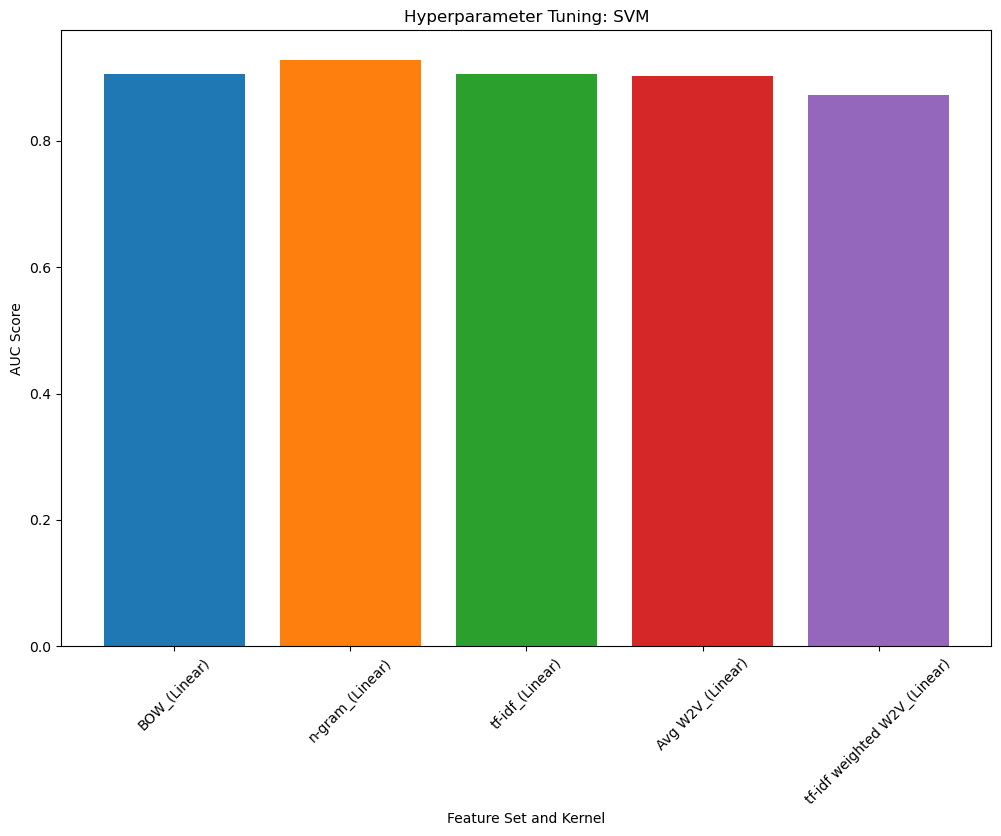


Confusion Matrix for BOW_(Linear):
 [[655 143]
 [185 517]]

Confusion Matrix for n-gram_(Linear):
 [[655 143]
 [185 517]]

Confusion Matrix for tf-idf_(Linear):
 [[696 102]
 [266 436]]

Confusion Matrix for Avg W2V_(Linear):
 [[696 102]
 [266 436]]

Confusion Matrix for tf-idf weighted W2V_(Linear):
 [[709  89]
 [279 423]]


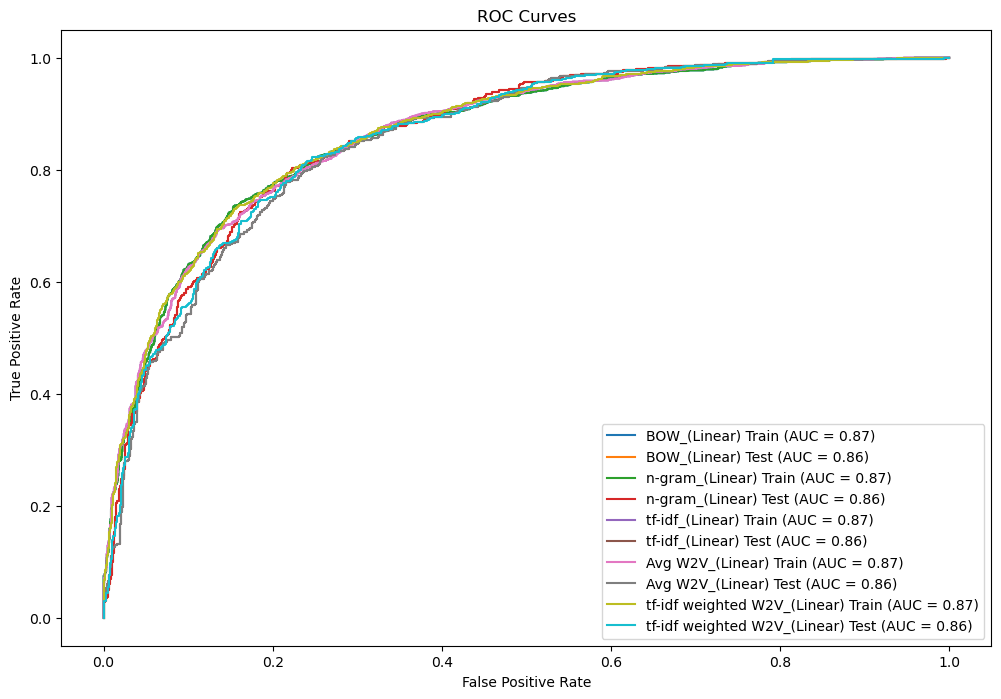

+------------------------------+-----------------------------------+--------------------+
|    Feature Set and Kernel    |            Best Params            |      Test AUC      |
+------------------------------+-----------------------------------+--------------------+
|         BOW_(Linear)         |  {'alpha': 0.01, 'penalty': 'l2'} | 0.9064113274639589 |
|       n-gram_(Linear)        |  {'alpha': 0.01, 'penalty': 'l2'} | 0.9287517226113717 |
|       tf-idf_(Linear)        | {'alpha': 0.001, 'penalty': 'l2'} | 0.9062381737820334 |
|       Avg W2V_(Linear)       | {'alpha': 0.001, 'penalty': 'l2'} | 0.902300266335354  |
| tf-idf weighted W2V_(Linear) | {'alpha': 0.001, 'penalty': 'l1'} | 0.8722036572913766 |
+------------------------------+-----------------------------------+--------------------+


In [62]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

# Initialize the X_labels and y_label
X_labels = [final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize hyperparameters for hyperparameter tuning
param_grid_linear = {'alpha': [10 ** x for x in range(-4, 5)], 'penalty': ['l1', 'l2']}
# param_grid_rbf = {'C': [10 ** x for x in range(-4, 5, 2)], 'gamma': [10 ** x for x in range(-4, 5, 2)]}

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores_linear = []
    auc_scores_rbf = []

    # Hyperparameter tuning using cross-validation for linear kernel
    with tqdm(total=len(param_grid_linear['alpha']) * len(param_grid_linear['penalty']), desc=f"X_label {i + 1} (Linear)") as pbar:
        for alpha in param_grid_linear['alpha']:
            for penalty in param_grid_linear['penalty']:
                clf_linear = GridSearchCV(SGDClassifier(loss='log_loss', random_state=42), param_grid_linear, cv=3, scoring='roc_auc', n_jobs=-1)
                clf_linear.fit(X_train, y_train)
                y_pred_prob_linear = clf_linear.predict_proba(X_test)[:, 1]
                auc_scores_linear.append(roc_auc_score(y_test, y_pred_prob_linear))
                pbar.update(1)
    
#     # Hyperparameter tuning using cross-validation for RBF kernel
#     X_train_rbf, X_test, y_train_rbf, y_test = train_test_split(X, y_label, test_size=0.3,random_state=42)
#     scaler = StandardScaler()
#     X_train_rbf = scaler.fit_transform(X_train_rbf)
#     with tqdm(total=len(param_grid_rbf['C']) * len(param_grid_rbf['gamma']), desc=f"X_label {i + 1} (RBF)") as pbar:
#         for C in param_grid_rbf['C']:
#             for gamma in param_grid_rbf['gamma']:
#                 clf_rbf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid_rbf, cv=3, scoring='roc_auc', n_jobs=-1)
#                 clf_rbf.fit(X_train_rbf, y_train_rbf)
#                 y_pred_prob_rbf = clf_rbf.predict_proba(X_test)[:, 1]
#                 auc_scores_rbf.append(roc_auc_score(y_test, y_pred_prob_rbf))
#                 pbar.update(1)
    
    results[f'{embedding[i]}_(Linear)'] = {'best_params': clf_linear.best_params_, 'auc_score': max(auc_scores_linear)}
#     results[f'{embedding[i]}_(RBF)'] = {'best_params': clf_rbf.best_params_, 'auc_score': max(auc_scores_rbf)}

    
# Plot performance on train and cross-validation data for each X_label and kernel
plt.figure(figsize=(12, 8))
for label, result in results.items():
    plt.bar(label, result['auc_score'])
plt.xlabel('Feature Set and Kernel')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.title('Hyperparameter Tuning: SVM')
plt.show()


# Find the best models for each X_label and kernel
best_models = {}
for label, result in results.items():
    best_params = result['best_params']
    if 'Linear' in label:
        best_models[label] = CalibratedClassifierCV(SGDClassifier(loss='log_loss', random_state=42, **best_params))
    elif 'RBF' in label:
        best_models[label] = SVC(kernel='rbf', probability=True, **best_params)

        
# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    if 'Linear' in label:
        X_train_scaled = StandardScaler().fit_transform(X_train)
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train_rbf, y_train_rbf)
    y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1] if 'Linear' in label else model.predict_proba(X_train_rbf)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()

# Summarize the results in a table
table = PrettyTable()
table.field_names = ["Feature Set and Kernel", "Best Params", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_params'], result['auc_score']])
print(table)

# [5.5] Decision tree

Feature Sets: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [06:44<00:00, 80.97s/it]


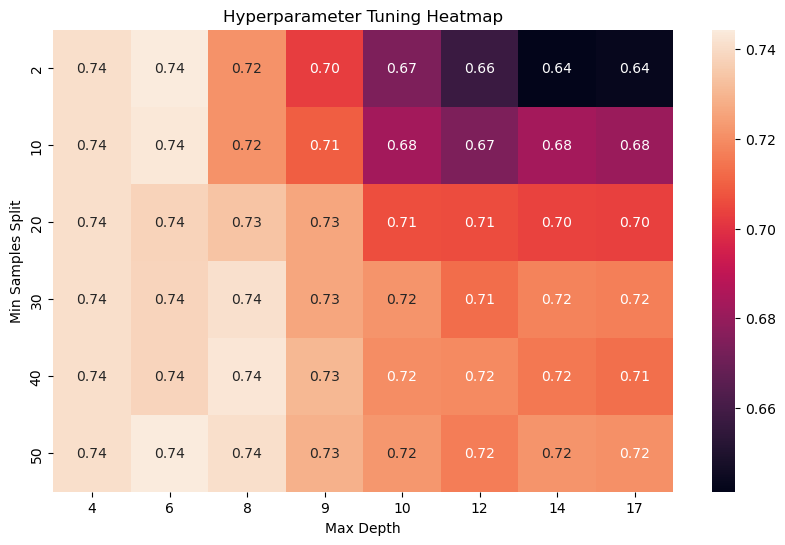


Confusion Matrix for BOW:
 [[486 312]
 [205 497]]

Confusion Matrix for n-gram:
 [[515 283]
 [234 468]]

Confusion Matrix for tf-idf:
 [[529 269]
 [242 460]]

Confusion Matrix for Avg W2V:
 [[575 223]
 [250 452]]

Confusion Matrix for tf-idf weighted W2V:
 [[475 323]
 [188 514]]


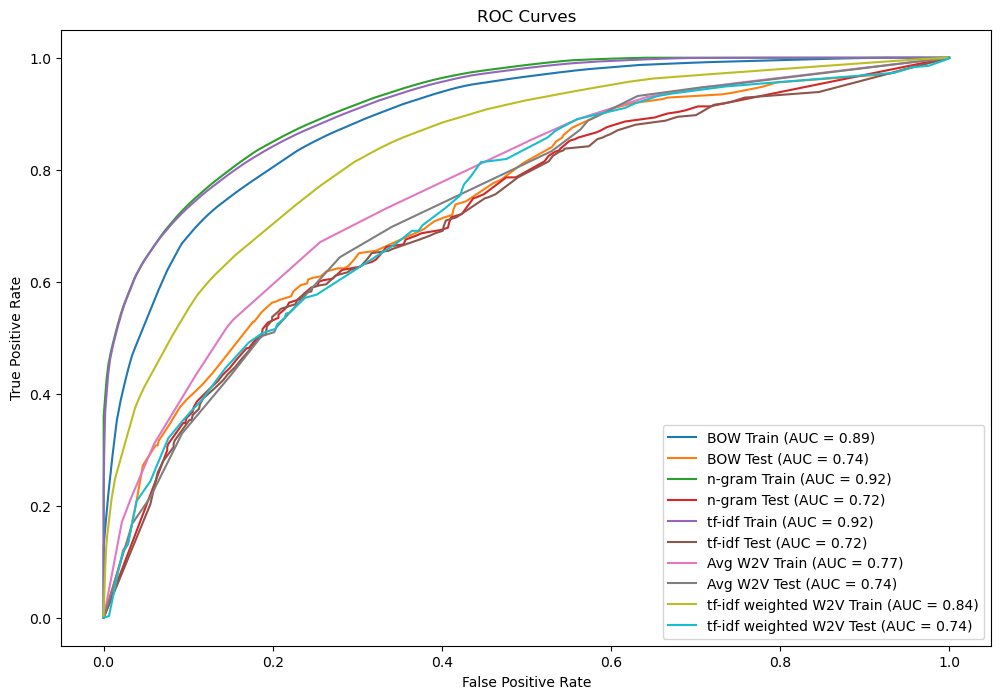

Top 20 Features for BOW:
Positive class: ['batch', 'amount', 'available', 'also', 'ago', 'around', 'baby', 'bad', 'black', 'bar', 'absolutely', 'aftertaste', 'another', 'anything', 'bottles', 'arrived', 'apple', 'bottle', 'actually', 'amazing']
Negative class: ['best', 'bite', 'although', 'almost', 'blue', 'believe', 'blend', 'awful', 'added', 'already', 'add', 'bottom', 'alternative', 'amazon', 'artificial', 'ate', 'beans', 'bit', 'bitter', 'able']

Top 20 Features for n-gram:
Positive class: ['batch', 'amount', 'available', 'also', 'ago', 'bad', 'baby', 'around', 'black', 'bar', 'absolutely', 'aftertaste', 'anything', 'arrived', 'bag', 'another', 'bottles', 'bottle', 'bags', 'actually']
Negative class: ['away', 'always', 'almost', 'awful', 'believe', 'best', 'bit', 'bite', 'bottom', 'able', 'blue', 'beans', 'alternative', 'blend', 'already', 'ate', 'amazon', 'artificial', 'bitter', 'add']

Top 20 Features for tf-idf:
Positive class: ['batch', 'amount', 'available', 'also', 'ago', 'ba

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from prettytable import PrettyTable
from IPython.display import Image
from sklearn import tree

# Initialize the X_labels and y_label
X_labels = [final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize hyperparameters for hyperparameter tuning
param_grid = {'max_depth': [4, 6, 8, 9, 10, 12, 14, 17],
              'min_samples_split': [2, 10, 20, 30, 40, 50]}

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(tqdm(X_labels,desc="Feature Sets")):
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores = []

    # Hyperparameter tuning using cross-validation
    for params in param_grid:
        clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]
        auc_scores.append(roc_auc_score(y_test, y_pred_prob))

    best_params = clf.best_params_
    results[f'{embedding[i]}'] = {'best_params': best_params, 'auc_score': max(auc_scores)}

    
# Hyperparameter tuning results visualization using heatmap
auc_matrix = np.zeros((len(param_grid['min_samples_split']), len(param_grid['max_depth'])))
for i, min_samples_split in enumerate(param_grid['min_samples_split']):
    for j, max_depth in enumerate(param_grid['max_depth']):
        model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc_matrix[i, j] = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
sns.heatmap(auc_matrix, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['min_samples_split'])
plt.xlabel('Max Depth')
plt.ylabel('Min Samples Split')
plt.title('Hyperparameter Tuning Heatmap')
plt.show()

# Find the best model for each X_label
best_models = {}
for label, result in results.items():
    best_params = result['best_params']
    best_models[label] = DecisionTreeClassifier(**best_params)

# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()    
    
# Visualize Decision Tree
# plt.figure(figsize=(12, 8))
# for label, model in best_models.items():
#     if 'BOW' in label or 'TF-IDF' in label:
#         dot_data = export_graphviz(model, out_file=None, filled=True, feature_names=None, class_names=['negative', 'positive'], max_depth=2)
#         graph = Source(dot_data)
#         graph.render(label, format='png', cleanup=True)
#         display(graph)

# Feature importance
top_features = {}
for label, model in best_models.items():
    if 'Avg W2V' in label or 'TFIDF W2V' in label:
        continue  # Skip Word2Vec related models
    if 'BOW' in label:
        feature_names = count_vect.get_feature_names_out()
    elif 'TF-IDF' in label:
        feature_names = tf_idf_vect.get_feature_names_out()
    top_features[label] = {'positive': [], 'negative': []}
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    for idx in sorted_indices[:20]:
        top_features[label]['positive'].append(feature_names[idx])
    for idx in sorted_indices[-20:]:
        top_features[label]['negative'].append(feature_names[idx])

# Print top features
for label, features in top_features.items():
    print(f'Top 20 Features for {label}:')
    print('Positive class:', features['positive'])
    print('Negative class:', features['negative'])
    print()


# Summarize the results in a table
table = PrettyTable()
table.field_names = ["Feature Set", "Best Params", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_params'], result['auc_score']])
print(table)

# [5.6] Random Forests and GBDT

BOW
RF


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.46s/it]


GBDT


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:42<00:00,  1.77s/it]


xg_boost


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:38<00:00,  6.61s/it]


n-gram
RF


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:47<00:00,  6.97s/it]


GBDT


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:00<00:00,  5.01s/it]


xg_boost


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [23:03<00:00, 57.65s/it]


tf-idf
RF


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.61s/it]


GBDT


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:25<00:00,  3.58s/it]


xg_boost


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [03:17<00:00,  8.24s/it]


Avg W2V
RF


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [05:03<00:00, 12.65s/it]


GBDT


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [04:33<00:00, 11.41s/it]


xg_boost


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:30<00:00,  3.79s/it]


tf-idf weighted W2V
RF


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [04:54<00:00, 12.26s/it]


GBDT


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [04:57<00:00, 12.38s/it]


xg_boost


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:37<00:00,  4.05s/it]


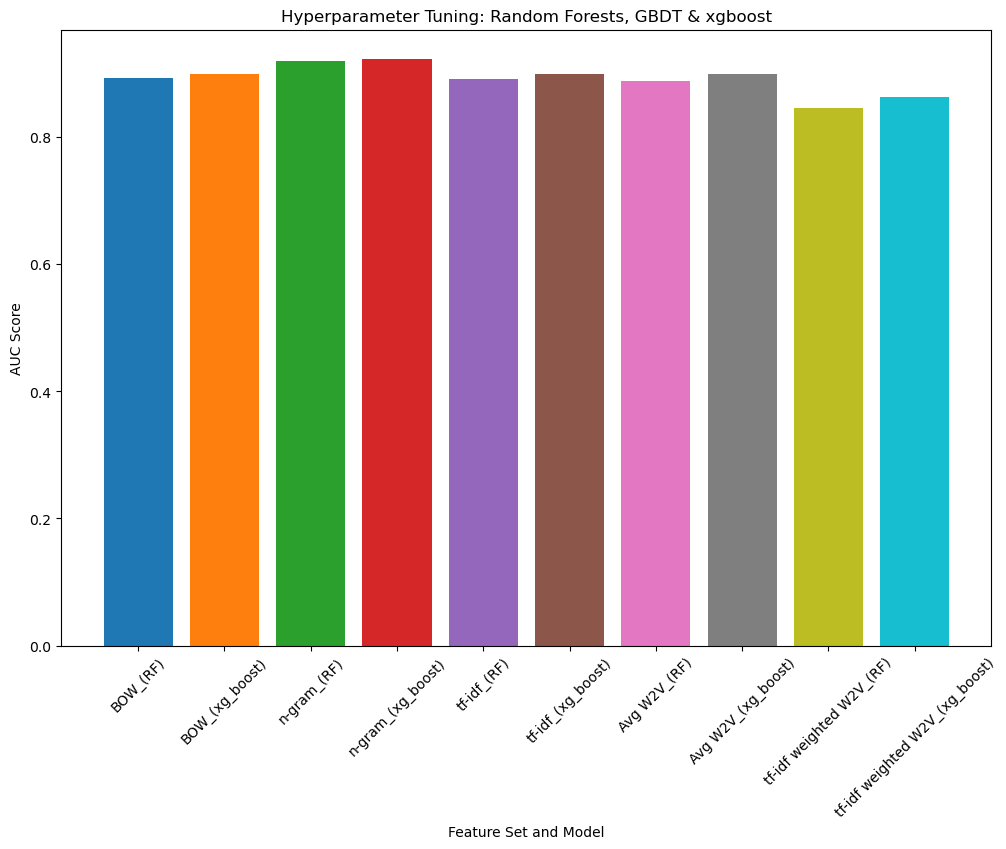


Confusion Matrix for BOW_(RF):
 [[584 214]
 [141 561]]

Confusion Matrix for BOW_(xg_boost):
 [[618 180]
 [137 565]]

Confusion Matrix for n-gram_(RF):
 [[584 214]
 [141 561]]

Confusion Matrix for n-gram_(xg_boost):
 [[618 180]
 [137 565]]

Confusion Matrix for tf-idf_(RF):
 [[584 214]
 [141 561]]

Confusion Matrix for tf-idf_(xg_boost):
 [[618 180]
 [137 565]]

Confusion Matrix for Avg W2V_(RF):
 [[584 214]
 [141 561]]

Confusion Matrix for Avg W2V_(xg_boost):
 [[618 180]
 [137 565]]

Confusion Matrix for tf-idf weighted W2V_(RF):
 [[584 214]
 [141 561]]

Confusion Matrix for tf-idf weighted W2V_(xg_boost):
 [[618 180]
 [137 565]]


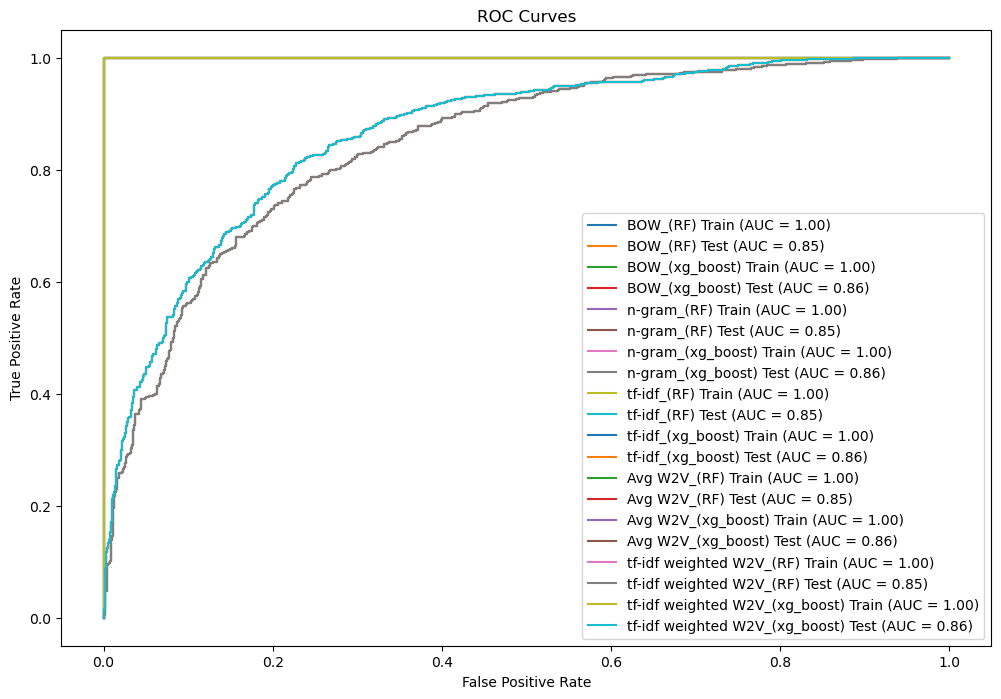

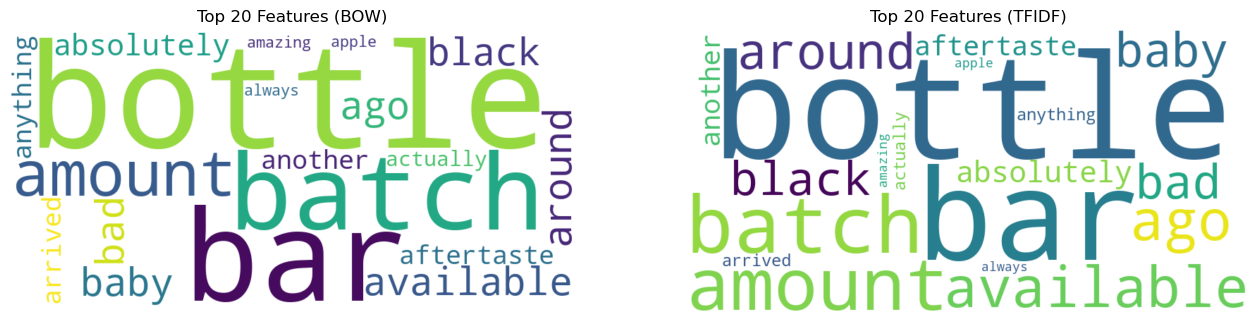

Top 20 Features for BOW_(RF):
Positive class: ['batch', 'available', 'amount', 'ago', 'bar', 'baby', 'also', 'black', 'bad', 'arrived', 'anything', 'around', 'aftertaste', 'actually', 'beans', 'bottles', 'best', 'another', 'away', 'ate']
Top 20 Features for n-gram_(RF):
Positive class: ['batch', 'available', 'amount', 'ago', 'bar', 'baby', 'also', 'black', 'bad', 'arrived', 'anything', 'around', 'aftertaste', 'actually', 'beans', 'bottles', 'best', 'another', 'away', 'ate']
Top 20 Features for tf-idf_(RF):
Positive class: ['batch', 'available', 'amount', 'ago', 'bar', 'baby', 'also', 'black', 'bad', 'arrived', 'anything', 'around', 'aftertaste', 'actually', 'beans', 'bottles', 'best', 'another', 'away', 'ate']
Top 20 Features for Avg W2V_(RF):
Positive class: ['batch', 'available', 'amount', 'ago', 'bar', 'baby', 'also', 'black', 'bad', 'arrived', 'anything', 'around', 'aftertaste', 'actually', 'beans', 'bottles', 'best', 'another', 'away', 'ate']
Top 20 Features for tf-idf weighted W2

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:45:59<00:00, 264.97s/it]


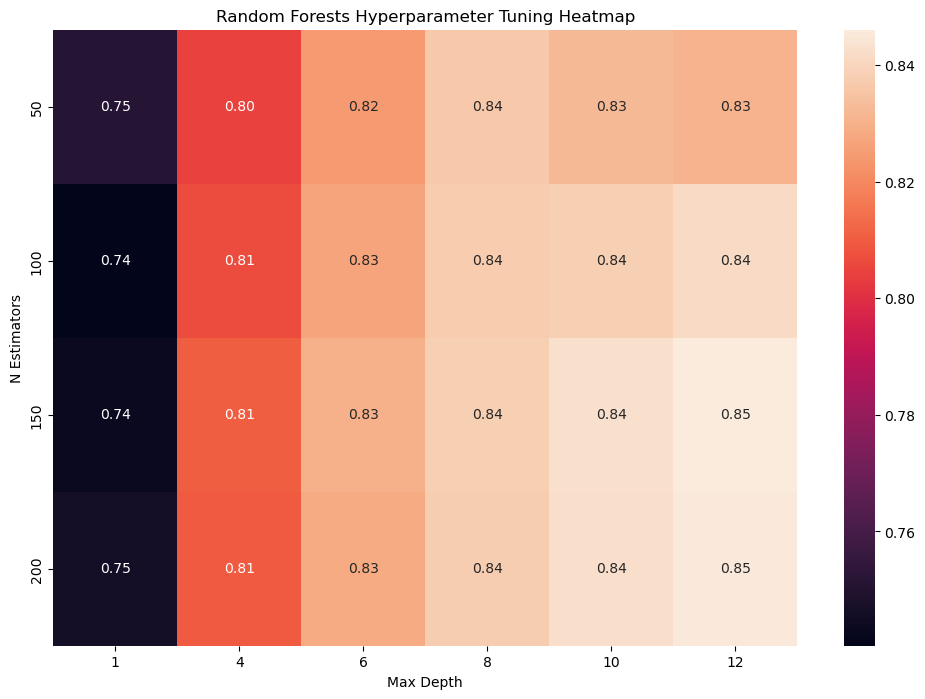

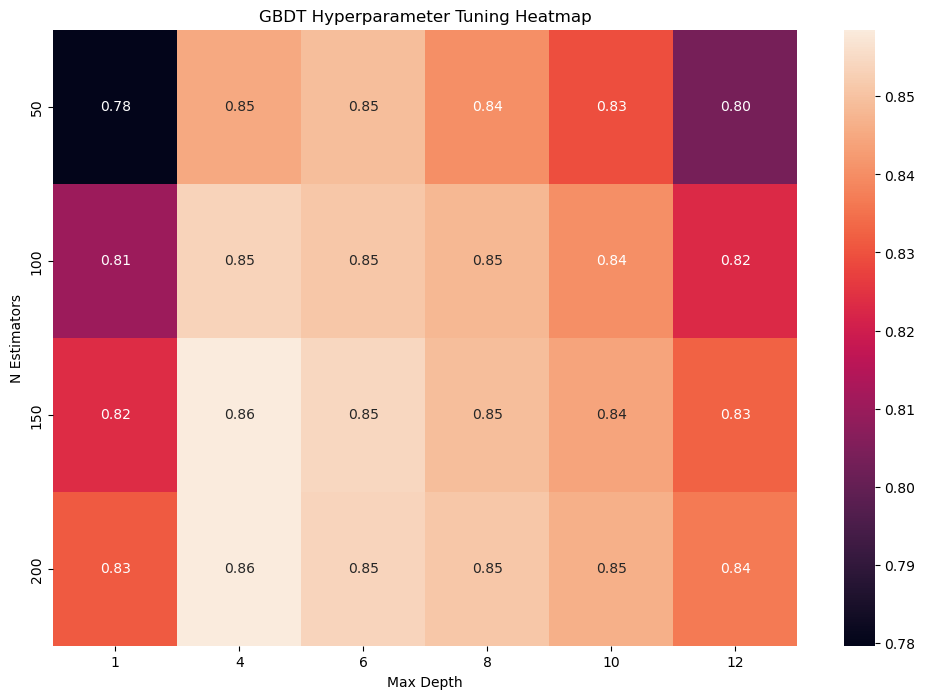

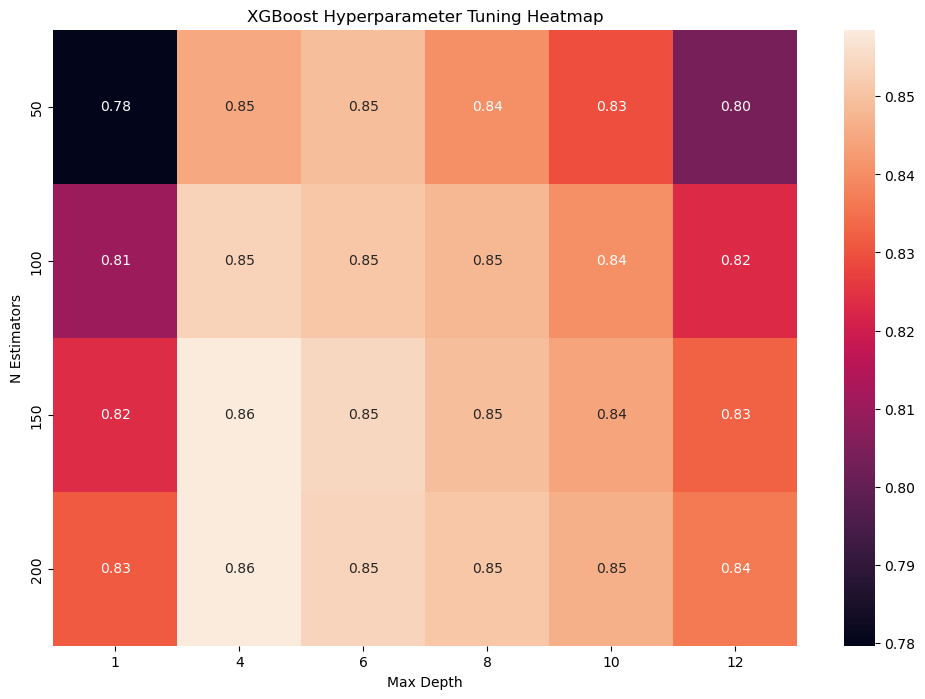

+--------------------------------+----------------------------------------+--------------------+
|     Feature Set and Model      |              Best Params               |      Test AUC      |
+--------------------------------+----------------------------------------+--------------------+
|            BOW_(RF)            | {'n_estimators': 200, 'max_depth': 12} | 0.892821441067055  |
|         BOW_(xg_boost)         | {'n_estimators': 200, 'max_depth': 12} | 0.900043913201808  |
|          n-gram_(RF)           | {'n_estimators': 200, 'max_depth': 12} | 0.920208284243372  |
|       n-gram_(xg_boost)        | {'n_estimators': 200, 'max_depth': 12} | 0.9230447914658441 |
|          tf-idf_(RF)           | {'n_estimators': 200, 'max_depth': 12} | 0.8916022249355581 |
|       tf-idf_(xg_boost)        | {'n_estimators': 200, 'max_depth': 12} | 0.8993709344586538 |
|          Avg W2V_(RF)          | {'n_estimators': 200, 'max_depth': 12} | 0.8888192703982178 |
|       Avg W2V_(xg_boost)    

In [64]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Initialize the X_labels and y_label
X_labels = [final_counts, final_bigram_counts,final_tf_idf, sent_vectors, tfidf_sent_vectors]
embedding = ["BOW","n-gram","tf-idf", "Avg W2V", "tf-idf weighted W2V"]
y_label = final['Score']

# Initialize hyperparameters for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [1, 4, 6, 8, 10, 12]
}

# Dictionary to store results
results = {}

# Loop over each X_label and train-test split
for i, X in enumerate(X_labels):
    print(embedding[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
    auc_scores_rf = []
    auc_scores_gbdt = []
    auc_scores_xgboost = []

    # Hyperparameter tuning using cross-validation for Random Forests
    print("RF")
    with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth'])) as pbar:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                clf_rf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
                clf_rf.fit(X_train, y_train)
                y_pred_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
                auc_scores_rf.append(roc_auc_score(y_test, y_pred_prob_rf))
                pbar.update(1)
    
    # Hyperparameter tuning using cross-validation for GBDT
    print("GBDT")
    with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth'])) as pbar:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                clf_rf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
                clf_rf.fit(X_train, y_train)
                y_pred_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
                auc_scores_rf.append(roc_auc_score(y_test, y_pred_prob_rf))
                pbar.update(1)
                
    # Hyperparameter tuning using cross-validation for XGBoost
    print("xg_boost")
    with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth'])) as pbar:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                clf_xgboost = XGBClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
                clf_xgboost.fit(X_train, y_train)
                y_pred_prob_xgboost = clf_xgboost.predict_proba(X_test)[:, 1]
                auc_scores_xgboost.append(roc_auc_score(y_test, y_pred_prob_xgboost))
                pbar.update(1)
    
    # results[f'{embedding[i]}_(RF)'] = {'best_params': {'n_estimators': clf_rf.n_estimators, 'max_depth': clf_rf.max_depth}, 'auc_score': max(auc_scores_rf)}
    # results[f'{embedding[i]}_(GBDT)'] = {'best_params': {'n_estimators': clf_gbdt.n_estimators, 'max_depth': clf_gbdt.max_depth}, 'auc_score': max(auc_scores_gbdt)}

    if auc_scores_rf:
        results[f'{embedding[i]}_(RF)'] = {'best_params': {'n_estimators': clf_rf.n_estimators, 'max_depth': clf_rf.max_depth}, 'auc_score': max(auc_scores_rf)}
    if auc_scores_gbdt:
        results[f'{embedding[i]}_(GBDT)'] = {'best_params': {'n_estimators': clf_gbdt.n_estimators, 'max_depth': clf_gbdt.max_depth}, 'auc_score': max(auc_scores_gbdt)}
    if auc_scores_xgboost:
        results[f'{embedding[i]}_(xg_boost)'] = {'best_params': {'n_estimators': clf_xgboost.n_estimators, 'max_depth': clf_xgboost.max_depth}, 'auc_score': max(auc_scores_xgboost)}

# Plot performance on train and cross-validation data for each X_label and model
plt.figure(figsize=(12, 8))
for label, result in results.items():
    plt.bar(label, result['auc_score'])
plt.xlabel('Feature Set and Model')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.title('Hyperparameter Tuning: Random Forests, GBDT & xgboost')
plt.show()

# Find the best models for each X_label and model
best_models = {}
for label, result in results.items():
    best_params = result['best_params']
    if 'RF' in label:
        best_models[label] = RandomForestClassifier(random_state=42, **best_params)
    elif 'GBDT' in label:
        best_models[label] = GradientBoostingClassifier(random_state=42, **best_params)
    elif 'xg_boost' in label:
        best_models[label] = XGBClassifier(random_state=42, **best_params)

# Train and evaluate the best models on test data
plt.figure(figsize=(12, 8))
for label, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Plot ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    plt.plot(fpr_train, tpr_train, label=f'{label} Train (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{label} Test (AUC = {test_auc:.2f})')

    # Print confusion matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'\nConfusion Matrix for {label}:\n', cm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()

# Visualization of top 20 important features as a word cloud for BOW & TFIDF
top_features_bow = top_features['BOW']['positive'] + top_features['tf-idf']['positive']
top_features_tfidf = top_features['BOW']['positive'] + top_features['tf-idf']['positive']
wordcloud_bow = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(' '.join(top_features_bow))
wordcloud_tfidf = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(' '.join(top_features_tfidf))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Features (BOW)')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Features (TFIDF)')
plt.show()

# Feature importance using feature_importances_ method
top_features_rf = {}
for label, model in best_models.items():
    if 'RF' in label:
        if 'BOW' in label:
            feature_names = count_vect.get_feature_names_out()
        elif 'TFIDF' in label:
            feature_names = tf_idf_vect.get_feature_names_out()
        top_features_rf[label] = {'positive': [], 'negative': []}
        feature_importances = model.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]
        for idx in sorted_indices[:20]:
            top_features_rf[label]['positive'].append(feature_names[idx])

# Print top features using feature_importances_
for label, features in top_features_rf.items():
    print(f'Top 20 Features for {label}:')
    print('Positive class:', features['positive'])


# Hyperparameter tuning results visualization using heatmap
auc_matrix_rf = np.zeros((len(param_grid['n_estimators']), len(param_grid['max_depth'])))
auc_matrix_gbdt = np.zeros((len(param_grid['n_estimators']), len(param_grid['max_depth'])))
auc_matrix_xgb = np.zeros((len(param_grid['n_estimators']), len(param_grid['max_depth'])))

with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth'])) as pbar:
    for i, n_estimators in enumerate(param_grid['n_estimators']):
        for j, max_depth in enumerate(param_grid['max_depth']):
            
            # Random Forests
            model_rf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
            model_rf.fit(X_train, y_train)
            y_pred_prob_rf = model_rf.predict_proba(X_test)[:, 1]
            auc_matrix_rf[i, j] = roc_auc_score(y_test, y_pred_prob_rf)

            # Gradient Boosting
            model_gbdt = GradientBoostingClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
            model_gbdt.fit(X_train, y_train)
            y_pred_prob_gbdt = model_gbdt.predict_proba(X_test)[:, 1]
            auc_matrix_gbdt[i, j] = roc_auc_score(y_test, y_pred_prob_gbdt)

            # XGBoost
            model_xgb = XGBClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
            model_gbdt.fit(X_train, y_train)
            y_pred_prob_gbdt = model_gbdt.predict_proba(X_test)[:, 1]
            auc_matrix_xgb[i, j] = roc_auc_score(y_test, y_pred_prob_gbdt)
            
            pbar.update(1)

# Plot heatmap for Random Forests hyperparameter tuning results
plt.figure(figsize=(12, 8))
sns.heatmap(auc_matrix_rf, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'])
plt.xlabel('Max Depth')
plt.ylabel('N Estimators')
plt.title('Random Forests Hyperparameter Tuning Heatmap')
plt.show()

# Plot heatmap for GBDT hyperparameter tuning results
plt.figure(figsize=(12, 8))
sns.heatmap(auc_matrix_gbdt, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'])
plt.xlabel('Max Depth')
plt.ylabel('N Estimators')
plt.title('GBDT Hyperparameter Tuning Heatmap')
plt.show()

# Plot heatmap for XGBoost hyperparameter tuning results
plt.figure(figsize=(12, 8))
sns.heatmap(auc_matrix_xgb, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'])
plt.xlabel('Max Depth')
plt.ylabel('N Estimators')
plt.title('XGBoost Hyperparameter Tuning Heatmap')
plt.show()

# Summarize the results in a table
table = PrettyTable()
table.field_names = ["Feature Set and Model", "Best Params", "Test AUC"]
for label, result in results.items():
    table.add_row([label, result['best_params'], result['auc_score']])
print(table)